# Imports

In [1]:
import torch
import os
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.io import read_image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaskaran320 (teamjs). Use `wandb login --relogin` to force relogin


True

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# seed_everything(42)

In [2]:
# images = ([os.path.join('../Data/Updated VOC/images', x) for x in image_files])
# masks = ([os.path.join('../Data/Updated VOC/masks', x) for x in mask_files])

# images = ([os.path.join('../Data/Updated VOC/images', x) for x in os.listdir('../Data/VOC Segmentation Dataset/images/')])
# masks = ([os.path.join('../Data/Updated VOC/masks', x) for x in os.listdir('../Data/VOC Segmentation Dataset/masks/')])

images = ([os.path.join('../Data/VOC Segmentation Dataset/images', x) for x in os.listdir('../Data/VOC Segmentation Dataset/images/')])
masks = ([os.path.join('../Data/VOC Segmentation Dataset/masks', x) for x in os.listdir('../Data/VOC Segmentation Dataset/masks/')])

In [3]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.1)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2)

# Part 1

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None, transform_bool=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.transform_bool= transform_bool

    def transformation(self, image, mask):
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])
        image = transform(image)
        mask = transform(mask)
        return image, mask

    def __len__(self):
        return len(self.images_dir)

    def __getitem__(self, index):

        image = read_image(self.images_dir[index])
        mask = read_image(self.masks_dir[index])
        image = torch.div(image, 255)

        # image = image / 255
        
        mask = torch.where(mask == 255, torch.tensor(0), mask)
        # mask = np.where(mask == 255, 0, mask)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.transform(mask)

        if self.transform_bool:
            image, mask = self.transformation(image, mask)

        return image, mask

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARING_RATE = 1e-4
BATCH_SIZE = 5
NUM_EPOCHS = 10
NUM_CLASSES = 21 # 20 classes + background 
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
MEAN = [0.485, 0.456, 0.406]
STD_DEV = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Normalize(mean=MEAN, std=STD_DEV),
])

In [6]:
train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
val_dataset = SegmentationDataset(val_images, val_masks, transform=transform)
test_dataset = SegmentationDataset(test_images, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Data Distribution

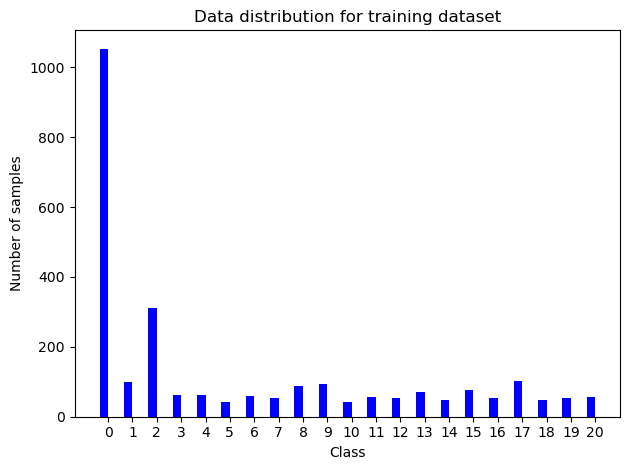

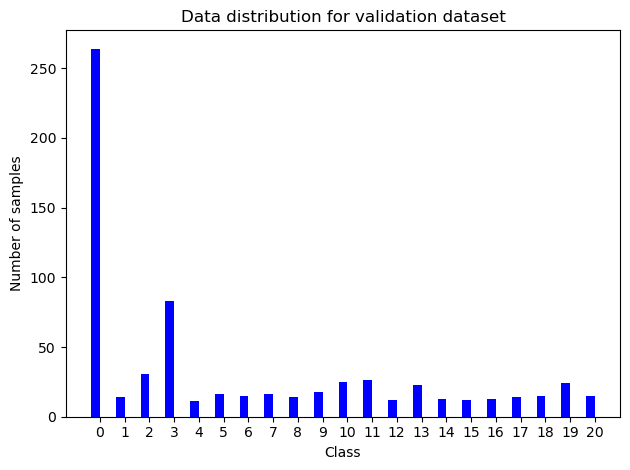

In [60]:
def get_data_distribution (data, flag=True):
    dic = {}
    for _, masks in data:
        masks = masks * 255
        for mask in masks:
            unique = np.unique(mask.numpy())
            for i in unique:
                if i not in dic:
                    dic[i] = 1
                else:
                    dic[i] += 1

    fig, ax = plt.subplots()
    index = np.arange(len(dic))
    bar_width = 0.35

    ax.bar(index, dic.values(), bar_width, color='b')
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Data distribution for training dataset' if flag else 'Data distribution for validation dataset')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(index)

    fig.tight_layout()
    plt.show()

get_data_distribution(train_loader)
get_data_distribution(val_loader, flag=False)

# Part 2

In [7]:
weights = models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.fcn_resnet50(weights = weights).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARING_RATE)

In [9]:
wandb.init(project="cv_assignment_1", entity="teamjs", name="Q2.2")
wandb.config = {
    "epochs": NUM_EPOCHS,
    "learning_rate": LEARING_RATE,
    "batch_size": BATCH_SIZE,
}
wandb.watch(model, log="all")

[]

In [7]:
def calculate_pixel_accuracy(predicted, labels):
    predicted = predicted.view(-1)
    labels = labels.view(-1)
    correct_pixels = torch.eq(predicted, labels).sum().item()
    accuracy = correct_pixels / predicted.shape[0]

    return accuracy

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_acc = 0
        val_running_loss = 0.0
        val_epoch_acc = 0
        for _, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.float().to(DEVICE)
            labels = labels.squeeze().long().to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)['out']

            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_acc += calculate_pixel_accuracy(preds, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = epoch_acc / len(train_loader)
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_acc:.4f}")

        with torch.no_grad():
            for _, (val_inputs, val_labels) in enumerate(val_loader):
                val_inputs = val_inputs.float().to(DEVICE)
                val_labels = val_labels.squeeze().long().to(DEVICE)
                val_outputs = model(val_inputs)['out']
                
                _, val_preds = torch.max(val_outputs, 1)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                val_epoch_acc += calculate_pixel_accuracy(val_preds, val_labels) 

            val_epoch_loss = val_running_loss / len(val_loader)
            val_epoch_acc = val_epoch_acc / len(val_loader)
            val_losses.append(val_epoch_loss)
            val_acc.append(val_epoch_acc)
            print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_epoch_loss:.4f} - Validation Accuracy: {val_epoch_acc:.4f}")
            
        wandb.log({"Training Loss": epoch_loss, "Validation Loss": val_epoch_loss})
        wandb.log({"Training Accuracy": epoch_acc, "Validation Accuracy": val_epoch_acc})
    return train_losses, val_losses, train_acc, val_acc

In [12]:
train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, epochs=NUM_EPOCHS)

Epoch 1/10 - Training Loss: 0.3345 - Training Accuracy: 0.8957
Epoch 1/10 - Validation Loss: 0.4120 - Validation Accuracy: 0.8720
Epoch 2/10 - Training Loss: 0.2643 - Training Accuracy: 0.9138
Epoch 2/10 - Validation Loss: 0.4418 - Validation Accuracy: 0.8671
Epoch 3/10 - Training Loss: 0.2376 - Training Accuracy: 0.9238
Epoch 3/10 - Validation Loss: 0.4150 - Validation Accuracy: 0.8778
Epoch 4/10 - Training Loss: 0.1913 - Training Accuracy: 0.9367
Epoch 4/10 - Validation Loss: 0.4197 - Validation Accuracy: 0.8826
Epoch 5/10 - Training Loss: 0.1522 - Training Accuracy: 0.9484
Epoch 5/10 - Validation Loss: 0.3879 - Validation Accuracy: 0.8869
Epoch 6/10 - Training Loss: 0.1302 - Training Accuracy: 0.9550
Epoch 6/10 - Validation Loss: 0.3714 - Validation Accuracy: 0.8916
Epoch 7/10 - Training Loss: 0.1150 - Training Accuracy: 0.9598
Epoch 7/10 - Validation Loss: 0.4064 - Validation Accuracy: 0.8876
Epoch 8/10 - Training Loss: 0.1123 - Training Accuracy: 0.9603
Epoch 8/10 - Validation Los

In [13]:
torch.save(model.state_dict(), "model_1.pth")
artifact = wandb.Artifact('model_2_1', type='model')
artifact.add_file('model_1.pth')
wandb.log_artifact(artifact)

In [7]:
# weights = models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
# model = models.segmentation.fcn_resnet50(weights = weights).to(DEVICE)
# model.load_state_dict(torch.load("model_1.pth"))

<All keys matched successfully>

In [14]:
# def compute_classwise_metrics(true_labels, predictions, num_classes, threshold_range=(0.0, 1.0, 0.1)):

#     metrics = {cls: {'precision': [], 'recall': [], 'f1': [], 'iou': [], 'accuracy': []} for cls in range(num_classes)}

#     for cls in range(num_classes):
#         y_true_cls = (true_labels == cls).astype(int)
#         y_scores_cls = predictions[:, cls]

#         for threshold in np.arange(*threshold_range):

#             # binarize the predicted scores using the threshold
#             y_pred_cls = (y_scores_cls >= threshold).astype(int)

#             # true positives, false positives, false negatives
#             tp = ((y_pred_cls == 1) & (y_true_cls == 1)).sum()
#             fp = ((y_pred_cls == 1) & (y_true_cls == 0)).sum()
#             fn = ((y_pred_cls == 0) & (y_true_cls == 1)).sum()
#             tn = ((y_pred_cls == 0) & (y_true_cls == 0)).sum()

#             # precision and recall
#             precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
#             recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
#             f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
#             iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
#             accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0

#             # append to metrics dictionary
#             metrics[cls]['precision'].append(precision)
#             metrics[cls]['recall'].append(recall)
#             metrics[cls]['f1'].append(f1)
#             metrics[cls]['iou'].append(iou)
#             metrics[cls]['accuracy'].append(accuracy)

#     return metrics

In [8]:
# testing the model
def test(model, test_loader):
    predictions = np.array([])
    true_labels = np.array([])
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)['out']
            _, predicted = torch.max(outputs.data, 1)
            predictions = np.append(predictions, predicted.cpu().numpy())
            true_labels = np.append(true_labels, labels.cpu().numpy())

    conf_matrix = confusion_matrix(true_labels, predictions)

    return conf_matrix, predictions, true_labels

# def test(model, test_loader):
#     predictions = []
#     true_labels = []
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data
#             images, labels = images.to(DEVICE), labels.to(DEVICE)
#             outputs = model(images)['out']
#             predicted = torch.nn.functional.softmax(outputs, dim=1)
#             predictions.append(predicted.cpu().numpy())
#             true_labels.append(labels.cpu().numpy())

#     predictions = np.concatenate(predictions, axis=0)
#     true_labels = np.concatenate(true_labels, axis=0)
#     # conf_matrix = metrics.confusion_matrix(true_labels, np.argmax(predictions, axis=1))

#     return conf_matrix, predictions, true_labels

In [35]:
# def average_precision(precision, recall):
#     sorted_indices = sorted(range(len(precision)), key=lambda i: precision[i], reverse=True)
#     precision = [precision[i] for i in sorted_indices]
#     recall = [recall[i] for i in sorted_indices]
    
#     prev_recall = 0
#     ap = 0
#     for i in range(len(precision)):
#         recall_diff = recall[i][9] - prev_recall
#         ap += precision[i][9] * recall_diff
#         prev_recall = recall[i][9]

#     return ap

In [39]:
def compute_iou(pred_masks, true_masks):
    intersection = (pred_masks & true_masks).sum(axis=(-1, -2))
    union = (pred_masks | true_masks).sum(axis=(-1, -2))
    ious = intersection / union
    return ious

In [57]:
def visualize_iou_mismatch(model, test_loader):
    model.eval()
    with torch.no_grad():
        for _, (images, masks) in enumerate(test_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)['out']
            predicted_masks = torch.sigmoid(outputs) > 0.5
            ious = compute_iou(predicted_masks.cpu().numpy(), masks.cpu().numpy())

            # Loop over each class and select 3 images with IoU <= 0.5
            for c in range(NUM_CLASSES):
                mismatch_indices = np.where((ious[:,c] <= 0.5) & (masks[:,c,:,:].sum(axis=(-1,-2)).cpu().numpy() > 0))[0][:3]
                if len(mismatch_indices) == 0:
                    break

                # Plot the selected images
                fig, axs = plt.subplots(3, 3, figsize=(10, 10))
                for j, idx in enumerate(mismatch_indices):
                    axs[j, 0].imshow(images[idx].cpu().permute(1, 2, 0))
                    axs[j, 0].axis('off')
                    axs[j, 0].set_title(f'Image {idx}')
                    axs[j, 1].imshow(masks[idx, c].cpu())
                    axs[j, 1].axis('off')
                    axs[j, 1].set_title('Ground Truth')
                    axs[j, 2].imshow(predicted_masks[idx, c].cpu(), cmap = 'gray')
                    axs[j, 2].axis('off')
                    axs[j, 2].set_title('Predicted')
                fig.suptitle(f'IoU <= 0.5')
                if len(mismatch_indices) > 0:
                    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


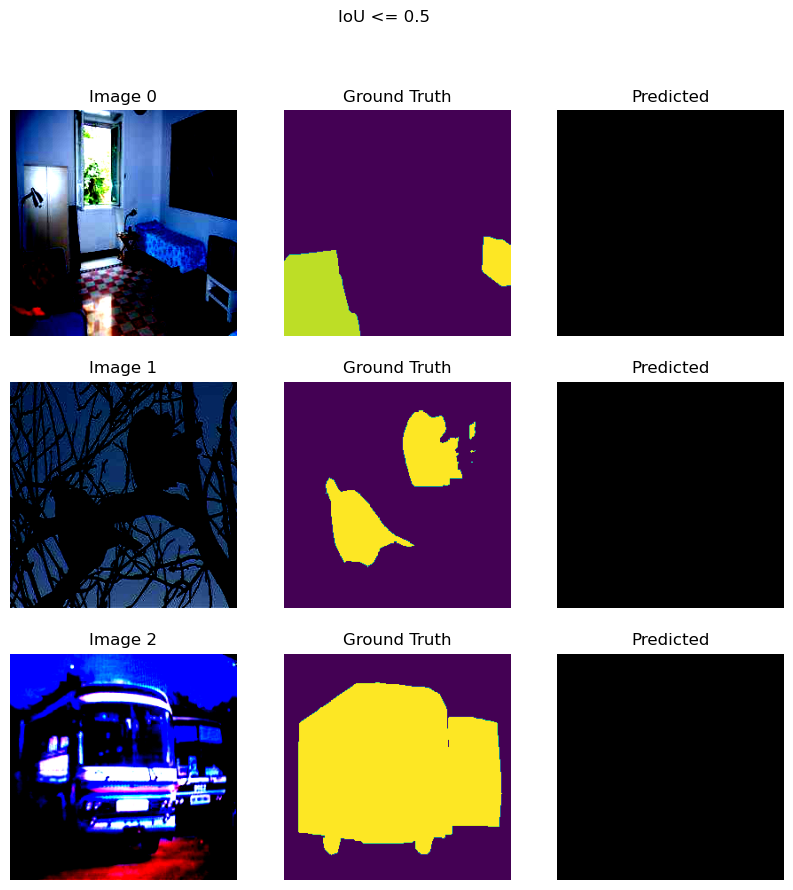

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [58]:
visualize_iou_mismatch(model, test_loader)

In [7]:
# calculate metrics
def calculate_metrics(conf_matrix):
    precisions = []
    recalls = []
    for i in range(NUM_CLASSES):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        tn = conf_matrix.sum() - (tp + fp + fn)

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        precisions.append(precision)
        recall = tp / (tp + fn)
        recalls.append(recall)
        f1 = 2 * (precision * recall) / (precision + recall)
        iou = tp / (tp + fp + fn)


        print(f"Class {i} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1-Score: {f1:.4f} - IoU: {iou:.4f}")
        # wandb.log({"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1, "IoU": iou})

    # ap = average_precision(precisions, recalls)
    ap = sum(precisions) / len(precisions)

    print(f'Average precision score: {ap:.4f}')
    # wandb.log({'Average precision score': ap})

In [17]:
# conf_matrix, predictions, true_labels = test(model, test_loader)
# metrics = compute_classwise_metrics(true_labels, predictions, NUM_CLASSES)

In [ ]:
# precisions = []
# recalls = []
# for cls, metrics_dict in metrics.items():
#     print(f"Class {cls}:")

#     precision = metrics_dict['precision']
#     print(f'Precision: {precision}')
#     recall = metrics_dict['recall']
#     print(f'Recall: {recall}')
#     print(f'F1 Score: {metrics_dict["f1"]}')
#     print(f'IOU: {metrics_dict["iou"]}')
#     precisions.append(precision)
#     recalls.append(recall)
#     print()

# ap = average_precision(precisions, recalls)
# print(f"Average Precision: {ap}")

In [23]:
conf_matrix, predictions, true_labels = test(model, test_loader)
calculate_metrics(conf_matrix)

Class 0 - Accuracy: 0.9404 - Precision: 0.9481 - Recall: 0.9756 - F1-Score: 0.9616 - IoU: 0.9261
Class 1 - Accuracy: 0.9984 - Precision: 0.8245 - Recall: 0.9431 - F1-Score: 0.8798 - IoU: 0.7855
Class 2 - Accuracy: 0.9987 - Precision: 0.5633 - Recall: 0.5531 - F1-Score: 0.5581 - IoU: 0.3871
Class 3 - Accuracy: 0.9978 - Precision: 0.8796 - Recall: 0.7509 - F1-Score: 0.8102 - IoU: 0.6809
Class 4 - Accuracy: 0.9982 - Precision: 0.7892 - Recall: 0.7489 - F1-Score: 0.7685 - IoU: 0.6241
Class 5 - Accuracy: 0.9968 - Precision: 0.8448 - Recall: 0.6701 - F1-Score: 0.7474 - IoU: 0.5966
Class 6 - Accuracy: 0.9982 - Precision: 0.9635 - Recall: 0.9313 - F1-Score: 0.9471 - IoU: 0.8996
Class 7 - Accuracy: 0.9981 - Precision: 0.9264 - Recall: 0.8906 - F1-Score: 0.9082 - IoU: 0.8318
Class 8 - Accuracy: 0.9960 - Precision: 0.8932 - Recall: 0.9429 - F1-Score: 0.9173 - IoU: 0.8473
Class 9 - Accuracy: 0.9885 - Precision: 0.7965 - Recall: 0.3399 - F1-Score: 0.4765 - IoU: 0.3127
Class 10 - Accuracy: 0.9987 - 

In [18]:
# wandb.finish()

Accuracy,▁██████▇███▇███▇██▇█▇
Average Precision,▁
F1-Score,█▇▃▆▅▆▇▅█▃▆▄▄▆▆▇▄▇▃▅▁
IoU,█▆▂▅▄▅▇▄▇▂▅▃▃▅▅▆▄▇▂▄▁
Precision,▇▇▁█▆▆██▇▄▇▆▄▇▆▆▇█▆▃▃
Recall,█▆▃▅▅▆▇▄█▂▅▃▄▅▆▇▃▇▂▅▁
Training Accuracy,▁▃▅▆▆▆▇██▇
Training Loss,█▅▄▃▃▂▂▁▁▂
Validation Accuracy,▁▂▃▂▆▃▆█▅▂
Validation Loss,▃▃▂▂▂▃▃▁▃█
Accuracy,0.98781


# Part 3

In [11]:
train_dataset = SegmentationDataset(train_images, train_masks, transform_bool=True)
val_dataset = SegmentationDataset(val_images, val_masks)
test_dataset = SegmentationDataset(test_images, test_masks)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
weights = models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.fcn_resnet50(weights = weights).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARING_RATE)

In [13]:
wandb.init(project="cv_assignment_1", entity="teamjs", name="Q2.3")
wandb.config = {
    "epochs": NUM_EPOCHS,
    "learning_rate": LEARING_RATE,
    "batch_size": BATCH_SIZE,
}
wandb.watch(model, log="all")

[]

In [14]:
train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, epochs=NUM_EPOCHS)

Epoch 1/10 - Training Loss: 0.7399 - Training Accuracy: 0.7998
Epoch 1/10 - Validation Loss: 0.6155 - Validation Accuracy: 0.8163
Epoch 2/10 - Training Loss: 0.6121 - Training Accuracy: 0.8205
Epoch 2/10 - Validation Loss: 0.6238 - Validation Accuracy: 0.8214
Epoch 3/10 - Training Loss: 0.5891 - Training Accuracy: 0.8227
Epoch 3/10 - Validation Loss: 0.5979 - Validation Accuracy: 0.8342
Epoch 4/10 - Training Loss: 0.5400 - Training Accuracy: 0.8347
Epoch 4/10 - Validation Loss: 0.5966 - Validation Accuracy: 0.8385
Epoch 5/10 - Training Loss: 0.5176 - Training Accuracy: 0.8391
Epoch 5/10 - Validation Loss: 0.5798 - Validation Accuracy: 0.8382
Epoch 6/10 - Training Loss: 0.4860 - Training Accuracy: 0.8436
Epoch 6/10 - Validation Loss: 0.6313 - Validation Accuracy: 0.8306
Epoch 7/10 - Training Loss: 0.4420 - Training Accuracy: 0.8544
Epoch 7/10 - Validation Loss: 0.5743 - Validation Accuracy: 0.8437
Epoch 8/10 - Training Loss: 0.4540 - Training Accuracy: 0.8495
Epoch 8/10 - Validation Los

In [15]:
torch.save(model.state_dict(), "model_2.pth")
artifact = wandb.Artifact('model_2_2', type='model')
artifact.add_file('model_2.pth')
wandb.log_artifact(artifact)

In [9]:
# weights = models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
# model = models.segmentation.fcn_resnet50(weights = weights).to(DEVICE)
# model.load_state_dict(torch.load("model_2.pth"))

<All keys matched successfully>

In [ ]:
conf_matrix = test(model, test_loader)
calculate_metrics(conf_matrix)

In [17]:
wandb.finish()

Accuracy,▁███████▇███▇██▇██▇▇█
Average Precision,▁
F1-Score,█▃▁▅▆▃▇▇▅ ▆▅▃▆▅▅▇▄▃▄▄
IoU,█▃▁▄▅▃▇▆▄▁▅▄▂▅▄▅▆▃▂▄▃
Precision,██▆▆█▆█▇█▁▆▆▇█▅▆▇█▆█▇
Recall,█▃▁▄▅▃▇▆▄▁▆▅▂▅▅▅▆▃▃▃▃
Training Accuracy,▁▄▄▅▆▆█▇██
Training Loss,█▅▅▄▃▂▁▂▁▁
Validation Accuracy,▁▂▅▆▆▄▇█▇▅
Validation Loss,▆▇▅▄▃▇▃▂▁█
Accuracy,0.99742
